In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np
import random
from shapely.geometry import Point, Polygon, box
from shapely.ops import transform as shapely_transform
import pyproj
from datetime import datetime, timedelta
import time
import os
import rasterio
from rasterio.transform import rowcol
import json
import math
import warnings

# --- Configuration ---
CSV_PATH = r"/home/px4_sitl/ets_work/montreal_research/thermal_synthetic_data_generation/synthetic_generated_data/synthetic_thermal_data_5yr_landcover.csv"
GEOJSON_PATH = r"/home/px4_sitl/ets_work/montreal_research/thermal_synthetic_data_generation/montreal_government_data/df.geojson"
LAND_COVER_PATH = r"/home/px4_sitl/ets_work/montreal_research/thermal_synthetic_data_generation/montreal_government_data/landcover-2020-classification.tif"
OUTPUT_FOLDER = r"/home/px4_sitl/ets_work/montreal_research/thermal_synthetic_data_generation/notebook/phase1"
PROB_MAP_FILENAME = "conditional_probability_map.npy"
METADATA_FILENAME = "probability_map_metadata.json"


GRID_RESOLUTION = 100.0 # meters

# --- Time Parameters ---
end_time = datetime.now()
start_time = end_time - timedelta(days=5*365)
total_seconds_in_period = (end_time - start_time).total_seconds()
thermal_months = [5, 6, 7, 8, 9]
min_thermal_hour = 10
max_thermal_hour = 18

# --- Thermal Properties ---
thermal_categories = {
    "Weak": ([0.5, 1.5], [50, 150], [300, 1000], [5, 15], 0.4),
    "Medium": ([1.5, 3.0], [100, 300], [800, 2000], [10, 30], 0.35),
    "Strong": ([3.0, 5.0], [150, 400], [1500, 3000], [15, 45], 0.2),
    "Very Strong": ([5.0, 7.0], [150, 500], [2000, 4000], [20, 60], 0.05)
}
category_names = list(thermal_categories.keys())
category_weights = [thermal_categories[cat][4] for cat in category_names]

# --- Land Cover Mapping ---
# !! Verify/Complete this mapping based on XML metadata !!
land_cover_names_inv = {
    "Needleleaf Forest": 1, "Taiga Forest": 2, "Broadleaf Forest": 5, "Mixed Forest": 6,
    "Shrubland": 8, "Grassland": 10, "Shrubland-Lichen-Moss": 11, "Grassland-Lichen-Moss": 12,
    "Barren-Lichen-Moss": 13, "Wetland": 14, "Cropland": 15, "Barren lands": 16,
    "Urban": 17, "Water": 18, "Snow/Ice": 19, "NoData": 0, "Unknown": 0
}
# !! Review and adjust these probabilities !!
land_cover_probabilities = {
    1: 0.20, 2: 0.20, 5: 0.25, 6: 0.22, 8: 0.40, 10: 0.50,
    11: 0.30, 12: 0.40, 13: 0.35, 14: 0.10, 15: 0.70, 16: 0.75,
    17: 0.85, 18: 0.01, 19: 0.00, 0: 0.00, 'default': 0.1
}

# --- Context Index Mapping ---
season_map = {"Spring/Fall": 0, "Summer": 1}
time_of_day_map = {"Morning": 0, "Afternoon": 1, "Late Afternoon": 2}
land_cover_codes_present = list(range(20))
land_cover_map_idx = {code: idx for idx, code in enumerate(land_cover_codes_present)}
num_lc_cats = len(land_cover_codes_present)
num_season_cats = len(season_map)
num_tod_cats = len(time_of_day_map)

# --- Generation Parameters ---
approx_active_hours = 5 * len(thermal_months) * 30 * (max_thermal_hour - min_thermal_hour)
thermals_per_active_hour_avg_density = 5
total_thermals_to_generate = approx_active_hours * thermals_per_active_hour_avg_density

MIN_DIST_FACTOR = 3.0
RECENT_POINTS_CHECK = 50
MAX_SPATIAL_ATTEMPTS = 200
MAX_TIMESTAMP_ATTEMPTS = 100

# --- Helper Functions ---
def get_season_idx(month):
    if month in [6, 7, 8]: return season_map["Summer"]
    if month in [5, 9]: return season_map["Spring/Fall"]
    return None

def get_tod_idx(hour):
    if 10 <= hour < 12: return time_of_day_map["Morning"]
    if 12 <= hour < 16: return time_of_day_map["Afternoon"]
    if 16 <= hour < 18: return time_of_day_map["Late Afternoon"]
    return None

# --- Main Script ---
start_exec_time = time.time()
print("--- Phase 1: Offline Conditional Probability Map Generation ---")

print(f"Loading synthetic data from: {CSV_PATH}")
try:
    thermal_df = pd.read_csv(CSV_PATH, parse_dates=['timestamp_utc'])
    thermal_df.dropna(subset=['easting', 'northing', 'land_cover_type'], inplace=True)
    default_lc_code = 0
    thermal_df['land_cover_code'] = thermal_df['land_cover_type'].apply(lambda x: land_cover_names_inv.get(x, default_lc_code))
    print(f"Loaded {len(thermal_df)} thermal events.")
except Exception as e:
    print(f"Error loading or processing CSV file: {e}")
    exit()

print(f"Loading GeoJSON: {GEOJSON_PATH}")
try:
    gdf_regions = gpd.read_file(GEOJSON_PATH)
    source_crs_geojson = gdf_regions.crs if gdf_regions.crs else "EPSG:32188"
    if gdf_regions.crs is None: gdf_regions.crs = source_crs_geojson
    print(f"GeoJSON CRS: {source_crs_geojson}")
except Exception as e:
    print(f"Error reading GeoJSON file: {e}")
    exit()

print(f"Loading Land Cover Raster: {LAND_COVER_PATH}")
try:
    lc_raster = rasterio.open(LAND_COVER_PATH)
    source_crs_raster = lc_raster.crs
    print(f"Land Cover CRS: {source_crs_raster}")
    transform_geojson_to_raster = None
    transform_raster_to_geojson = None
    if source_crs_raster != source_crs_geojson:
        print("CRS mismatch detected. Setting up transformations.")
        transformer_g2r = pyproj.Transformer.from_crs(source_crs_geojson, source_crs_raster, always_xy=True)
        transform_geojson_to_raster = transformer_g2r.transform
        transformer_r2g = pyproj.Transformer.from_crs(source_crs_raster, source_crs_geojson, always_xy=True)
        transform_raster_to_geojson = transformer_r2g.transform
    else:
        print("CRS match.")
except Exception as e:
    print(f"Error opening land cover file or setting up transformer: {e}")
    exit()

print(f"Defining grid with {GRID_RESOLUTION}m resolution based on GeoJSON bounds...")
geojson_bounds_native = gdf_regions.total_bounds
geojson_bbox = box(*geojson_bounds_native)
if transform_geojson_to_raster:
    try:
        geojson_bounds_transformed = shapely_transform(transform_geojson_to_raster, geojson_bbox).bounds
        min_x_grid, min_y_grid, max_x_grid, max_y_grid = geojson_bounds_transformed
    except Exception as e:
        print(f"Error transforming GeoJSON bounds: {e}. Exiting.")
        exit()
else:
    min_x_grid, min_y_grid, max_x_grid, max_y_grid = geojson_bounds_native

grid_origin_x = math.floor(min_x_grid / GRID_RESOLUTION) * GRID_RESOLUTION
grid_origin_y = math.ceil(max_y_grid / GRID_RESOLUTION) * GRID_RESOLUTION
grid_width = math.ceil((max_x_grid - grid_origin_x) / GRID_RESOLUTION)
grid_height = math.ceil((grid_origin_y - min_y_grid) / GRID_RESOLUTION)
grid_affine = rasterio.Affine(GRID_RESOLUTION, 0.0, grid_origin_x,
                              0.0, -GRID_RESOLUTION, grid_origin_y)

print(f"Grid Dimensions (Width x Height): {grid_width} x {grid_height}")
print(f"Grid CRS: {source_crs_raster}")

print("Initializing count maps...")
try:
    thermal_counts = np.zeros((grid_height, grid_width, num_season_cats, num_tod_cats, num_lc_cats), dtype=np.float32)
    total_context_counts = np.zeros((num_season_cats, num_tod_cats, num_lc_cats), dtype=np.float32)
except MemoryError:
    print("\nERROR: Unable to allocate memory for count arrays.")
    print(f"Calculated grid size: {grid_height} x {grid_width} with {num_season_cats*num_tod_cats*num_lc_cats} context layers.")
    print("Consider increasing GRID_RESOLUTION (e.g., 200, 500) or reducing context complexity.")
    exit()
except Exception as e:
    print(f"Error initializing numpy arrays: {e}")
    exit()

print("Binning synthetic data and calculating counts...")
skipped_points = 0
for _, event in thermal_df.iterrows():
    timestamp = event['timestamp_utc']
    season_idx = get_season_idx(timestamp.month)
    tod_idx = get_tod_idx(timestamp.hour)

    if season_idx is None or tod_idx is None:
        skipped_points += 1
        continue

    point_x_geojson, point_y_geojson = event['easting'], event['northing']

    coords_for_raster = (point_x_geojson, point_y_geojson)
    if transform_geojson_to_raster:
        try:
             coords_for_raster = transform_geojson_to_raster(point_x_geojson, point_y_geojson)
        except Exception as e:
             skipped_points += 1
             continue

    try:
        row_idx, col_idx = rasterio.transform.rowcol(grid_affine, coords_for_raster[0], coords_for_raster[1])
        lc_code = event['land_cover_code']
        lc_idx = land_cover_map_idx.get(lc_code)

        if 0 <= row_idx < grid_height and 0 <= col_idx < grid_width and lc_idx is not None:
            indices = (row_idx, col_idx, season_idx, tod_idx, lc_idx)
            thermal_counts[indices] += 1
            total_context_counts[season_idx, tod_idx, lc_idx] += 1
        else:
            skipped_points += 1
    except IndexError:
        skipped_points +=1
    except Exception as e:
        skipped_points += 1

print(f"Finished binning. Skipped {skipped_points} points (outside time/grid/context).")

print("Calculating smoothed probabilities...")
num_locations = float(grid_width * grid_height) # Use float for division consistency
total_context_counts_reshaped = total_context_counts[np.newaxis, np.newaxis, :, :, :]
denominator = total_context_counts_reshaped + num_locations
epsilon = 1e-9 # Small epsilon to prevent explicit divide-by-zero if denominator is exactly zero

# --- Corrected Probability Calculation using np.where ---
calculated_prob = (thermal_counts + 1.0) / (denominator + epsilon) # Laplace smoothing (add 1)
baseline_prob = 1.0 / (num_locations + epsilon) if num_locations > 0 else epsilon # Avoid K=0 case, use epsilon

# Where denominator > 0 (meaning total_context_count was >= 0), use calculated prob.
# Where denominator == 0 (should only happen if num_locations is 0, very unlikely), use baseline.
# More directly: where total_context_counts is 0, the calculated prob is (0+1)/(0+K) = 1/K
# Where total_context_counts > 0, use the calculated value.

# Use np.where based on the original total_context_counts (before adding K)
# Need to reshape total_context_counts appropriately for the condition in np.where
prob_map = np.where(total_context_counts_reshaped > 0, calculated_prob, baseline_prob)
prob_map = np.clip(prob_map, 0.0, 1.0)
# --- End Correction ---


print("Saving probability map and metadata...")
prob_map_output_path = os.path.join(OUTPUT_FOLDER, PROB_MAP_FILENAME)
metadata_output_path = os.path.join(OUTPUT_FOLDER, METADATA_FILENAME)

try:
    np.save(prob_map_output_path, prob_map)
    print(f"Probability map saved to {prob_map_output_path}")
except Exception as e:
    print(f"Error saving probability map: {e}")

if transform_raster_to_geojson:
    grid_origin_x_geojson, grid_origin_y_geojson = transform_raster_to_geojson(grid_origin_x, grid_origin_y)
else:
    grid_origin_x_geojson, grid_origin_y_geojson = grid_origin_x, grid_origin_y

metadata = {
    "description": "Conditional Probability Map P(Thermal | GridCell, Season, TimeOfDay, LandCoverCode)",
    "generated_on": datetime.now().isoformat(),
    "source_synthetic_data": CSV_PATH,
    "source_land_cover_data": LAND_COVER_PATH,
    "source_geojson_boundaries": GEOJSON_PATH,
    "grid_crs": str(source_crs_raster),
    "grid_dimensions": {"height": grid_height, "width": grid_width},
    "grid_resolution": GRID_RESOLUTION,
    "grid_affine_transform_gdal": list(grid_affine.to_gdal()),
    "grid_origin_in_geojson_crs": {"x": grid_origin_x_geojson, "y": grid_origin_y_geojson, "crs": str(source_crs_geojson)},
    "map_shape": prob_map.shape,
    "map_dimensions_order": ["y_index(row)", "x_index(col)", "season_index", "tod_index", "land_cover_index"],
    "context_mappings": {
        "season": season_map,
        "time_of_day": time_of_day_map,
        "land_cover_code_to_index": land_cover_map_idx
    },
    "probability_calculation": "Frequency count from synthetic data with Laplace smoothing (add 1), normalized by total count per context across all locations + K (num_locations)."
}

try:
    with open(metadata_output_path, 'w') as f:
        json.dump(metadata, f, indent=4)
    print(f"Metadata saved to {metadata_output_path}")
except Exception as e:
    print(f"Error saving metadata JSON: {e}")

lc_raster.close()
warnings.resetwarnings()
end_exec_time = time.time()
print(f"\nPhase 1 finished in {end_exec_time - start_exec_time:.2f} seconds.")

--- Phase 1: Offline Conditional Probability Map Generation ---
Loading synthetic data from: /home/px4_sitl/ets_work/montreal_research/thermal_synthetic_data_generation/synthetic_generated_data/synthetic_thermal_data_5yr_landcover.csv
Loaded 30000 thermal events.
Loading GeoJSON: /home/px4_sitl/ets_work/montreal_research/thermal_synthetic_data_generation/montreal_government_data/df.geojson
GeoJSON CRS: EPSG:32188
Loading Land Cover Raster: /home/px4_sitl/ets_work/montreal_research/thermal_synthetic_data_generation/montreal_government_data/landcover-2020-classification.tif
Land Cover CRS: EPSG:3979
CRS mismatch detected. Setting up transformations.
Defining grid with 100.0m resolution based on GeoJSON bounds...
Grid Dimensions (Width x Height): 513 x 481
Grid CRS: EPSG:3979
Initializing count maps...
Binning synthetic data and calculating counts...
Finished binning. Skipped 0 points (outside time/grid/context).
Calculating smoothed probabilities...
Saving probability map and metadata...

Loading metadata from: /home/px4_sitl/ets_work/montreal_research/thermal_synthetic_data_generation/notebook/phase1/probability_map_metadata.json
Loading counts map from: /home/px4_sitl/ets_work/montreal_research/thermal_synthetic_data_generation/notebook/phase1/thermal_counts_map.npy
Error loading counts map NumPy file: [Errno 2] No such file or directory: '/home/px4_sitl/ets_work/montreal_research/thermal_synthetic_data_generation/notebook/phase1/thermal_counts_map.npy'
Plotting slice: Season='Summer'(1), TimeOfDay='Afternoon'(1), LandCover='Urban'(Code=17, Index=17)
Extracted 2D count slice with shape: (481, 513)
Slice normalized (max count was 4)
Loading GeoJSON boundaries: /home/px4_sitl/ets_work/montreal_research/thermal_synthetic_data_generation/montreal_government_data/df.geojson
Transforming GeoJSON boundaries to EPSG:3979...
Generating plot...
Displaying plot...


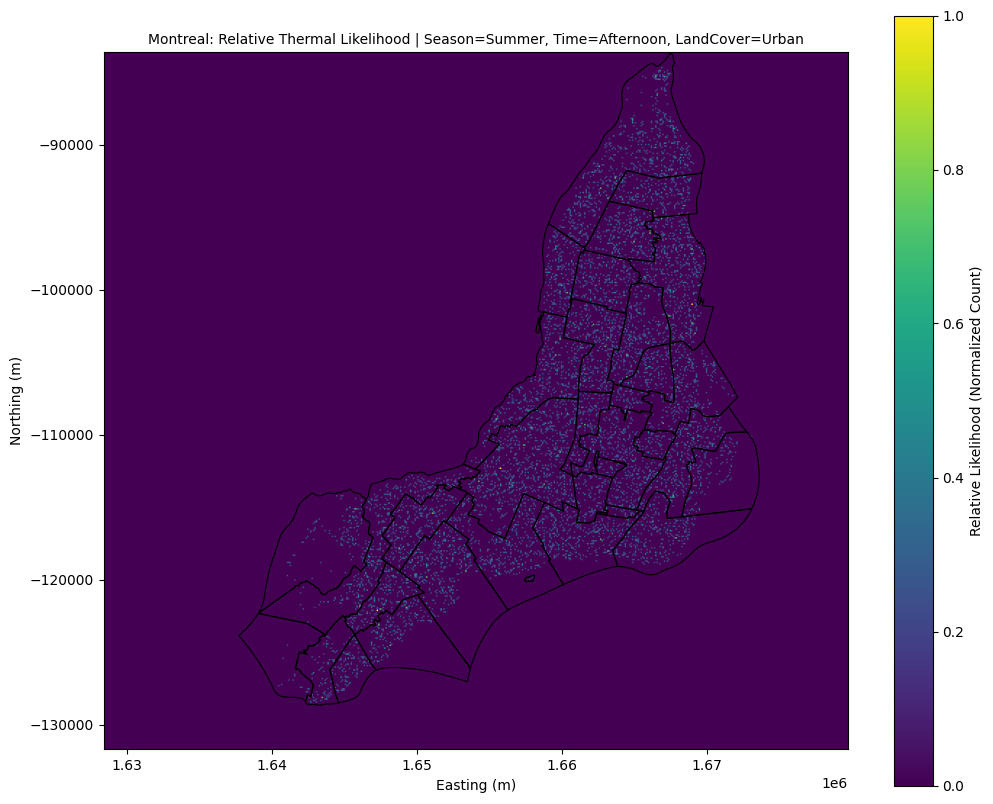

Plotting script finished.


: 

In [ ]:
import json
import numpy as np
import rasterio
import rasterio.plot
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D
import warnings

# --- Configuration ---
OUTPUT_FOLDER = r"/home/px4_sitl/ets_work/montreal_research/thermal_synthetic_data_generation/notebook/phase1"
METADATA_FILENAME = "probability_map_metadata.json"
# !! Load the COUNTS map now !!
COUNTS_MAP_FILENAME = "thermal_counts_map.npy"
GEOJSON_PATH = r"/home/px4_sitl/ets_work/montreal_research/thermal_synthetic_data_generation/montreal_government_data/df.geojson"

METADATA_PATH = os.path.join(OUTPUT_FOLDER, METADATA_FILENAME)
COUNTS_MAP_PATH = os.path.join(OUTPUT_FOLDER, COUNTS_MAP_FILENAME)

# --- Define the Context Slice to Visualize ---
TARGET_SEASON_NAME = "Summer"
TARGET_TOD_NAME = "Afternoon"
TARGET_LC_NAME = "Urban"

# --- Load Metadata and Counts Map ---
print(f"Loading metadata from: {METADATA_PATH}")
try:
    with open(METADATA_PATH, 'r') as f:
        metadata = json.load(f)
except Exception as e:
    print(f"Error loading metadata JSON file: {e}")
    exit()

print(f"Loading counts map from: {COUNTS_MAP_PATH}")
try:
    # Load the thermal_counts array
    thermal_counts = np.load(COUNTS_MAP_PATH)
except Exception as e:
    print(f"Error loading counts map NumPy file: {e}")
    exit()

# --- Extract Info from Metadata ---
try:
    grid_crs_str = metadata['grid_crs']
    grid_height = metadata['grid_dimensions']['height']
    grid_width = metadata['grid_dimensions']['width']
    grid_affine = rasterio.Affine.from_gdal(*metadata['grid_affine_transform_gdal'])
    map_shape = tuple(metadata['map_shape'])
    map_dims_order = metadata['map_dimensions_order']
    season_map = metadata['context_mappings']['season']
    tod_map = metadata['context_mappings']['time_of_day']
    lc_code_to_idx_map = metadata['context_mappings']['land_cover_code_to_index']

    land_cover_names_map = {
        1: "Needleleaf Forest", 2: "Taiga Forest", 5: "Broadleaf Forest", 6: "Mixed Forest",
        8: "Shrubland", 10: "Grassland", 11: "Shrubland-Lichen-Moss", 12: "Grassland-Lichen-Moss",
        13: "Barren-Lichen-Moss", 14: "Wetland", 15: "Cropland", 16: "Barren lands",
        17: "Urban", 18: "Water", 19: "Snow/Ice", 0: "NoData", "Unknown": 0
    }
    lc_name_to_code_map = {v: k for k, v in land_cover_names_map.items() if isinstance(k, int)}

    target_season_idx = season_map.get(TARGET_SEASON_NAME)
    target_tod_idx = tod_map.get(TARGET_TOD_NAME)
    target_lc_code = lc_name_to_code_map.get(TARGET_LC_NAME)
    target_lc_idx = lc_code_to_idx_map.get(str(target_lc_code))

    if target_season_idx is None or target_tod_idx is None or target_lc_idx is None:
        print(f"Error: Target context not found in metadata mappings.")
        exit()

    print(f"Plotting slice: Season='{TARGET_SEASON_NAME}'({target_season_idx}), TimeOfDay='{TARGET_TOD_NAME}'({target_tod_idx}), LandCover='{TARGET_LC_NAME}'(Code={target_lc_code}, Index={target_lc_idx})")

except KeyError as e:
    print(f"Error: Metadata file is missing expected key: {e}")
    exit()
except Exception as e:
    print(f"Error processing metadata: {e}")
    exit()

# --- Extract 2D Slice from Counts Map---
try:
    count_slice_2d = thermal_counts[:, :, target_season_idx, target_tod_idx, target_lc_idx]
    print(f"Extracted 2D count slice with shape: {count_slice_2d.shape}")

    # --- Normalize counts to 0-1 for relative likelihood visualization ---
    max_count = count_slice_2d.max()
    if max_count > 0:
        normalized_slice_2d = count_slice_2d / max_count
    else:
        normalized_slice_2d = count_slice_2d # Avoid division by zero if max is 0
    print(f"Slice normalized (max count was {max_count:.0f})")

except IndexError as e:
     print(f"Error extracting slice. Error: {e}")
     exit()
except Exception as e:
    print(f"Unexpected error extracting slice: {e}")
    exit()

# --- Load and Prepare Boundaries ---
print(f"Loading GeoJSON boundaries: {GEOJSON_PATH}")
try:
    gdf_regions = gpd.read_file(GEOJSON_PATH)
    if gdf_regions.crs is None: gdf_regions.crs = "EPSG:32188"
    if gdf_regions.crs != grid_crs_str:
        print(f"Transforming GeoJSON boundaries to {grid_crs_str}...")
        gdf_regions = gdf_regions.to_crs(grid_crs_str)
except Exception as e:
    print(f"Error loading or transforming GeoJSON file: {e}")
    exit()

# --- Plotting ---
print("Generating plot...")
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

try:
    # Plot the NORMALIZED counts slice
    image_hidden = rasterio.plot.show(normalized_slice_2d, ax=ax, transform=grid_affine, cmap='viridis')

    gdf_regions.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.8)

    img = image_hidden.get_images()[0]
    # Update colorbar label
    fig.colorbar(img, ax=ax, label='Relative Likelihood (Normalized Count)')

    plot_title = f"Montreal: Relative Thermal Likelihood | Season={TARGET_SEASON_NAME}, Time={TARGET_TOD_NAME}, LandCover={TARGET_LC_NAME}"
    ax.set_title(plot_title, fontsize=10)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.set_aspect('equal', adjustable='box')

    print("Displaying plot...")
    plt.show()

except Exception as e:
     print(f"Error during plotting: {e}")

print("Plotting script finished.")

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import random
from shapely.geometry import Point, Polygon, box
from shapely.ops import transform as shapely_transform
import pyproj
from datetime import datetime, timedelta
import time
import os
import rasterio
from rasterio.transform import rowcol
import json
import math
import warnings

# --- Configuration ---
CSV_PATH = r"C:\work\ETS_mirza\distributed_montreal\synthetic_thermal_data_5yr_landcover_name.csv"
GEOJSON_PATH = r"C:\work\ETS_mirza\distributed_montreal\df.geojson"
LAND_COVER_PATH = r"C:\work\ETS_mirza\distributed_montreal\dataset\landcover-2020-classification.tif"
OUTPUT_FOLDER = r"C:\work\ETS_mirza\distributed_montreal"
PROB_MAP_FILENAME = "conditional_probability_map.npy"
AVG_METRICS_MAP_FILENAME = "average_thermal_metrics.npz" # Changed to NPZ for multiple arrays
METADATA_FILENAME = "probability_map_metadata.json"

GRID_RESOLUTION = 100.0 # meters

# --- Time Parameters ---
end_time = datetime.now()
start_time = end_time - timedelta(days=5*365)
total_seconds_in_period = (end_time - start_time).total_seconds()
thermal_months = [5, 6, 7, 8, 9]
min_thermal_hour = 10
max_thermal_hour = 18

# --- Land Cover Mapping ---
# !! Verify/Complete this mapping based on XML metadata !!
land_cover_names_inv = {
    "Needleleaf Forest": 1, "Taiga Forest": 2, "Broadleaf Forest": 5, "Mixed Forest": 6,
    "Shrubland": 8, "Grassland": 10, "Shrubland-Lichen-Moss": 11, "Grassland-Lichen-Moss": 12,
    "Barren-Lichen-Moss": 13, "Wetland": 14, "Cropland": 15, "Barren lands": 16,
    "Urban": 17, "Water": 18, "Snow/Ice": 19, "NoData": 0, "Unknown": 0
}

# --- Context Index Mapping ---
season_map = {"Spring/Fall": 0, "Summer": 1}
time_of_day_map = {"Morning": 0, "Afternoon": 1, "Late Afternoon": 2}
land_cover_codes_present = list(range(20))
land_cover_map_idx = {code: idx for idx, code in enumerate(land_cover_codes_present)}
num_lc_cats = len(land_cover_codes_present)
num_season_cats = len(season_map)
num_tod_cats = len(time_of_day_map)

# --- Helper Functions ---
def get_season_idx(month):
    if month in [6, 7, 8]: return season_map["Summer"]
    if month in [5, 9]: return season_map["Spring/Fall"]
    return None

def get_tod_idx(hour):
    if 10 <= hour < 12: return time_of_day_map["Morning"]
    if 12 <= hour < 16: return time_of_day_map["Afternoon"]
    if 16 <= hour < 18: return time_of_day_map["Late Afternoon"]
    return None

# --- Main Script ---
start_exec_time = time.time()
print("--- Phase 1: Offline Conditional Probability & Average Metrics Map Generation ---")

print(f"Loading synthetic data from: {CSV_PATH}")
try:
    thermal_df = pd.read_csv(CSV_PATH, parse_dates=['timestamp_utc'])
    required_cols = ['easting', 'northing', 'land_cover_type', 'lift_rate_mps', 'radius_m', 'max_height_m_agl', 'duration_min']
    thermal_df.dropna(subset=required_cols, inplace=True)
    default_lc_code = 0
    thermal_df['land_cover_code'] = thermal_df['land_cover_type'].apply(lambda x: land_cover_names_inv.get(x, default_lc_code))
    print(f"Loaded {len(thermal_df)} thermal events with valid metrics.")
except Exception as e:
    print(f"Error loading or processing CSV file: {e}")
    exit()

print(f"Loading GeoJSON: {GEOJSON_PATH}")
try:
    gdf_regions = gpd.read_file(GEOJSON_PATH)
    source_crs_geojson = gdf_regions.crs if gdf_regions.crs else "EPSG:32188"
    if gdf_regions.crs is None: gdf_regions.crs = source_crs_geojson
    print(f"GeoJSON CRS: {source_crs_geojson}")
except Exception as e:
    print(f"Error reading GeoJSON file: {e}")
    exit()

print(f"Loading Land Cover Raster: {LAND_COVER_PATH}")
try:
    lc_raster = rasterio.open(LAND_COVER_PATH)
    source_crs_raster = lc_raster.crs
    print(f"Land Cover CRS: {source_crs_raster}")
    transform_geojson_to_raster = None
    transform_raster_to_geojson = None
    if source_crs_raster != source_crs_geojson:
        print("CRS mismatch detected. Setting up transformations.")
        transformer_g2r = pyproj.Transformer.from_crs(source_crs_geojson, source_crs_raster, always_xy=True)
        transform_geojson_to_raster = transformer_g2r.transform
        transformer_r2g = pyproj.Transformer.from_crs(source_crs_raster, source_crs_geojson, always_xy=True)
        transform_raster_to_geojson = transformer_r2g.transform
    else:
        print("CRS match.")
except Exception as e:
    print(f"Error opening land cover file or setting up transformer: {e}")
    exit()

print(f"Defining grid with {GRID_RESOLUTION}m resolution based on GeoJSON bounds...")
geojson_bounds_native = gdf_regions.total_bounds
geojson_bbox = box(*geojson_bounds_native)
if transform_geojson_to_raster:
    try:
        geojson_bounds_transformed = shapely_transform(transform_geojson_to_raster, geojson_bbox).bounds
        min_x_grid, min_y_grid, max_x_grid, max_y_grid = geojson_bounds_transformed
    except Exception as e:
        print(f"Error transforming GeoJSON bounds: {e}. Exiting.")
        exit()
else:
    min_x_grid, min_y_grid, max_x_grid, max_y_grid = geojson_bounds_native

grid_origin_x = math.floor(min_x_grid / GRID_RESOLUTION) * GRID_RESOLUTION
grid_origin_y = math.ceil(max_y_grid / GRID_RESOLUTION) * GRID_RESOLUTION
grid_width = math.ceil((max_x_grid - grid_origin_x) / GRID_RESOLUTION)
grid_height = math.ceil((grid_origin_y - min_y_grid) / GRID_RESOLUTION)
grid_affine = rasterio.Affine(GRID_RESOLUTION, 0.0, grid_origin_x,
                              0.0, -GRID_RESOLUTION, grid_origin_y)

print(f"Grid Dimensions (Width x Height): {grid_width} x {grid_height}")
print(f"Grid CRS: {source_crs_raster}")

print("Initializing count and sum maps...")
try:
    map_shape_5d = (grid_height, grid_width, num_season_cats, num_tod_cats, num_lc_cats)
    event_counts = np.zeros(map_shape_5d, dtype=np.float32)
    lift_sum = np.zeros(map_shape_5d, dtype=np.float32)
    radius_sum = np.zeros(map_shape_5d, dtype=np.float32)
    height_sum = np.zeros(map_shape_5d, dtype=np.float32)
    duration_sum = np.zeros(map_shape_5d, dtype=np.float32)

    total_context_counts = np.zeros((num_season_cats, num_tod_cats, num_lc_cats), dtype=np.float32)
except MemoryError:
    print("\nERROR: Unable to allocate memory for count/sum arrays.")
    exit()
except Exception as e:
    print(f"Error initializing numpy arrays: {e}")
    exit()

print("Binning synthetic data and calculating sums/counts...")
skipped_points = 0
for _, event in thermal_df.iterrows():
    timestamp = event['timestamp_utc']
    season_idx = get_season_idx(timestamp.month)
    tod_idx = get_tod_idx(timestamp.hour)

    if season_idx is None or tod_idx is None:
        skipped_points += 1
        continue

    point_x_geojson, point_y_geojson = event['easting'], event['northing']
    coords_for_raster = (point_x_geojson, point_y_geojson)
    if transform_geojson_to_raster:
        try: coords_for_raster = transform_geojson_to_raster(point_x_geojson, point_y_geojson)
        except Exception as e: skipped_points += 1; continue

    try:
        row_idx, col_idx = rasterio.transform.rowcol(grid_affine, coords_for_raster[0], coords_for_raster[1])
        lc_code = event['land_cover_code']
        lc_idx = land_cover_map_idx.get(lc_code)

        if 0 <= row_idx < grid_height and 0 <= col_idx < grid_width and lc_idx is not None:
            indices_5d = (row_idx, col_idx, season_idx, tod_idx, lc_idx)
            event_counts[indices_5d] += 1
            lift_sum[indices_5d] += event['lift_rate_mps']
            radius_sum[indices_5d] += event['radius_m']
            height_sum[indices_5d] += event['max_height_m_agl']
            duration_sum[indices_5d] += event['duration_min']

            indices_3d_context = (season_idx, tod_idx, lc_idx)
            total_context_counts[indices_3d_context] += 1
        else:
            skipped_points += 1
    except IndexError: skipped_points +=1
    except Exception as e: skipped_points += 1

print(f"Finished binning. Skipped {skipped_points} points.")

print("Calculating overall smoothed probabilities P(Thermal|Context)...")
num_locations = float(grid_width * grid_height)
total_context_counts_reshaped = total_context_counts[np.newaxis, np.newaxis, :, :, :]
denominator = total_context_counts_reshaped + num_locations
epsilon = 1e-9
calculated_prob = (event_counts + 1.0) / (denominator + epsilon) # Use event_counts now
baseline_prob = 1.0 / (num_locations + epsilon) if num_locations > 0 else epsilon
prob_map = np.where(total_context_counts_reshaped > 0, calculated_prob, baseline_prob)
prob_map = np.clip(prob_map, 0.0, 1.0)

print("Calculating average metrics...")
# Use np.errstate to avoid warnings for division by zero, result will be NaN
with np.errstate(divide='ignore', invalid='ignore'):
    avg_lift_map = np.where(event_counts > 0, lift_sum / event_counts, np.nan)
    avg_radius_map = np.where(event_counts > 0, radius_sum / event_counts, np.nan)
    avg_height_map = np.where(event_counts > 0, height_sum / event_counts, np.nan)
    avg_duration_map = np.where(event_counts > 0, duration_sum / event_counts, np.nan)

print("Saving probability map, average metrics map, and metadata...")
prob_map_output_path = os.path.join(OUTPUT_FOLDER, PROB_MAP_FILENAME)
avg_metrics_map_output_path = os.path.join(OUTPUT_FOLDER, AVG_METRICS_MAP_FILENAME)
metadata_output_path = os.path.join(OUTPUT_FOLDER, METADATA_FILENAME)

try:
    np.save(prob_map_output_path, prob_map)
    print(f"Probability map saved to {prob_map_output_path}")
    np.savez_compressed(avg_metrics_map_output_path,
                        avg_lift=avg_lift_map,
                        avg_radius=avg_radius_map,
                        avg_height=avg_height_map,
                        avg_duration=avg_duration_map)
    print(f"Average Metrics map saved to {avg_metrics_map_output_path}")
except Exception as e:
    print(f"Error saving map files: {e}")

if transform_raster_to_geojson:
    grid_origin_x_geojson, grid_origin_y_geojson = transform_raster_to_geojson(grid_origin_x, grid_origin_y)
else:
    grid_origin_x_geojson, grid_origin_y_geojson = grid_origin_x, grid_origin_y

metadata = {
    "description": "Conditional Probability Map P(Thermal | Context) and Average Thermal Metrics",
    "generated_on": datetime.now().isoformat(),
    "source_synthetic_data": CSV_PATH,
    "source_land_cover_data": LAND_COVER_PATH,
    "source_geojson_boundaries": GEOJSON_PATH,
    "grid_crs": str(source_crs_raster),
    "grid_dimensions": {"height": grid_height, "width": grid_width},
    "grid_resolution": GRID_RESOLUTION,
    "grid_affine_transform_gdal": list(grid_affine.to_gdal()),
    "grid_origin_in_geojson_crs": {"x": grid_origin_x_geojson, "y": grid_origin_y_geojson, "crs": str(source_crs_geojson)},
    "probability_map_file": PROB_MAP_FILENAME,
    "probability_map_shape": prob_map.shape,
    "probability_map_dimensions_order": ["y", "x", "season", "tod", "lc"],
    "average_metrics_map_file": AVG_METRICS_MAP_FILENAME,
    "average_metrics_map_content": ["avg_lift", "avg_radius", "avg_height", "avg_duration"],
    "average_metrics_map_shape": avg_lift_map.shape, # Shape is 5D for all avg maps
    "average_metrics_map_dimensions_order": ["y", "x", "season", "tod", "lc"],
    "context_mappings": {
        "season": season_map,
        "time_of_day": time_of_day_map,
        "land_cover_code_to_index": land_cover_map_idx
    },
    "probability_calculation": "Frequency count from synthetic data with Laplace smoothing (add 1), normalized by total count per context across all locations + K (num_locations)."
}

try:
    with open(metadata_output_path, 'w') as f:
        json.dump(metadata, f, indent=4)
    print(f"Metadata saved to {metadata_output_path}")
except Exception as e:
    print(f"Error saving metadata JSON: {e}")

lc_raster.close()
warnings.resetwarnings()
end_exec_time = time.time()
print(f"\nPhase 1 finished in {end_exec_time - start_exec_time:.2f} seconds.")

--- Phase 1: Offline Conditional Probability & Average Metrics Map Generation ---
Loading synthetic data from: C:\work\ETS_mirza\distributed_montreal\synthetic_thermal_data_5yr_landcover_name.csv
Error loading or processing CSV file: [Errno 2] No such file or directory: 'C:\\work\\ETS_mirza\\distributed_montreal\\synthetic_thermal_data_5yr_landcover_name.csv'
Loading GeoJSON: C:\work\ETS_mirza\distributed_montreal\df.geojson
Error reading GeoJSON file: C:\work\ETS_mirza\distributed_montreal\df.geojson: No such file or directory
Loading Land Cover Raster: C:\work\ETS_mirza\distributed_montreal\dataset\landcover-2020-classification.tif
Error opening land cover file or setting up transformer: C:\work\ETS_mirza\distributed_montreal\dataset\landcover-2020-classification.tif: No such file or directory
Defining grid with 100.0m resolution based on GeoJSON bounds...
Grid Dimensions (Width x Height): 513 x 481
Grid CRS: EPSG:3979
Initializing count and sum maps...
Binning synthetic data and cal

: 